### Introduction to ARCH and GARCH models

Various problems such as option pricing in finance have motivated the study of the volatility, or variability, of a time series. ARMA models were used to model the conditional mean of a process when the conditional variance was constant. In many problems, however, the assumption of a constant conditional variance will be violated. Models such as the autoregressive conditionally heteroscedastic or ARCH model were developed to model changes in volatility. These models were later extended to generalized ARCH, or GARCH models. 

In these problems, we are concerned with modeling the return or growth rate of a series. For example, if $x_t$ is the value of an asset at time $t$, then the return or relative gain, $r_t$, of the asset at time $t$ is

$$
r_t = \frac{x_t-x_{t-1}}{x_{t-1}}.
$$

If the return represents a small (in magnitude) percentage change then 

$$
\log(\frac{x_t}{x_{t-1}}) = \log(1+r_t) \approx r_t.
$$

Typically, for financial series, the return $r_t$, does not have a constant conditional variance, and highly volatile periods tend to be clustered together. In other words, there is a strong dependence of sudden bursts of variability in a return on the series own past.

The simplest ARCH model, the **ARCH(1)**, models the return as
$$
\begin{equation}
r_t = \mu+\epsilon_t\\
\epsilon_t = \sigma_t e_t, \ \ e_t ∼ \ N(0, 1)\\
\sigma_t^2 = \alpha_0 + \alpha_1 r^2_{t-1}.
\end{equation}
$$

The Normal assumption may be relaxed. We must impose some constraints on the model parameters to obtain desirable properties. An obvious constraint is that $\alpha_0, \alpha_1 \geq 0$ because $\sigma^2$ is a variance. 

The ARCH(1) models return as a white noise process with nonconstant conditional variance, and that conditional variance depends on the previous return. 

The ARCH(1) model can be extended to the general **ARCH(p) model** in an obvious way, by changing the last component in the definition

$$
\sigma_t^2 = \alpha_0 + \alpha_1 r^2_{t-1}+ ... +\alpha_p r^2_{t-p}.
$$

Estimation of the parameters $\alpha_0,\alpha_1,...,\alpha_p$ of the ARCH(p) model is typically accomplished by conditional MLE. The conditional likelihood of the data $r_{p+1},...,r_n$ given $r_1,...,r_p$, is given by

$$
L(\mu,\alpha) = p(r_1,...,r_p \ | \ \mu,\alpha)= 􏱴 \prod_{p+1}^n f_{\alpha}(r_t \ | \ 􏱢􏱢r_{t−1},...,r_{t−p}),
$$
where under the assumption of normality, the conditional densities $f_\alpha(\cdot | \cdot)$ are, for t > p, given by
$$
r_t | 􏱢r_{t-1},...,r_{t-p} ∼ N(0,\alpha_0 +\alpha_1r_{t-1}^2 +···+\alpha_p r_{t-p}^2 ).
$$
Here the constraints are $\alpha_i ≥ 0, i = 1,2,...,p$ and  $(\alpha_1 + · · · + \alpha_p ) < 1$.

The **GARCH(1,1) model** is defined by changing the last component in the following way

$$
\sigma_t^2 = \alpha_0 + \alpha_1 r^2_{t-1} + \beta_1\sigma^2_{t-1} .
$$

*Reference*:

  - *Time series analysis and it's aplications*, fourth edition, Robert H. Shumway and David S. Stoffer (2016)

### Load libraries and Federal Reserve FX Data

In [2]:
# Load packages

import pandas as pd
import numpy as np
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
import scipy.stats as scs
from arch.univariate import GARCH

plt.rc("figure", figsize=(12, 6))
plt.rc("font", family="sans-serif")
plt.rc("font", size=10)
plt.rc("lines", linewidth=1.5)
sns.set_style("darkgrid")

start = datetime.datetime(2005,10,15)
end = datetime.datetime(2015,10,15)

# Federal Reserve FX Data (FRED) from the St. Louis Federal Reserve
# U.S. Dollars to Euro Spot Exchange Rate

fx_useu = web.DataReader("DEXUSEU",'fred', start, end)

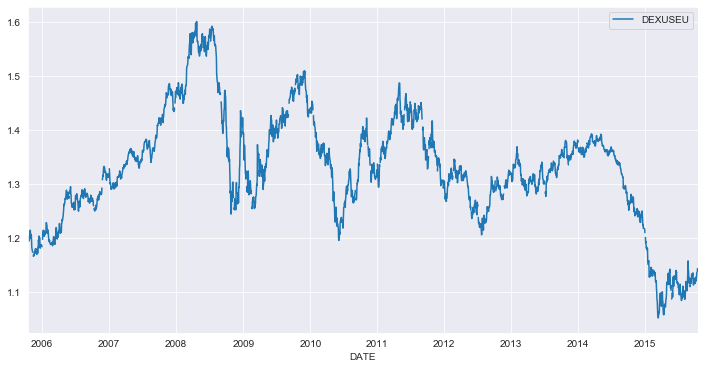

In [3]:
fx_useu.plot();

In [4]:
fx_useu.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2609 entries, 2005-10-17 to 2015-10-15
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DEXUSEU  2513 non-null   float64
dtypes: float64(1)
memory usage: 40.8 KB


In [5]:
# Check number of missing values
print(fx_useu.isna().sum())

DEXUSEU    96
dtype: int64


In [6]:
# Perform linear interpolation at missing data points
fx_useu = fx_useu.interpolate()

In [7]:
print(fx_useu.isna().sum())

DEXUSEU    0
dtype: int64


In [8]:
# Compute returns (log returns) of irregular daily time series
rets = np.log(fx_useu / fx_useu.shift(1))
rets.columns = ['Return']
rets = rets.dropna()

In [9]:
rets.head().round(3)

,Return
DATE,
2005-10-18,-0.008
2005-10-19,0.004
2005-10-20,-0.001
2005-10-21,-0.002
2005-10-24,0.003


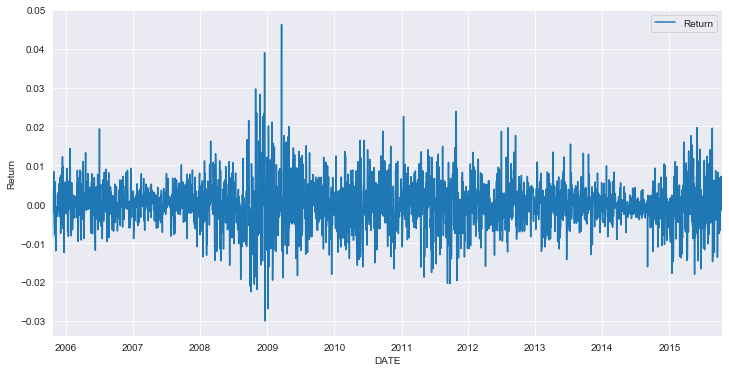

In [10]:
# Plot return
rets.plot(ylabel='Return');

Next we present two plots:

- A histogram of the returns is created and the Gaussian/normal density corresponding to the maximum-likelihood fit is drawn.
This graph may appear to display a reasonable fit, but other diagnostics are useful to evaluate whether the distribution is heavier-tailed than a Gaussian distribution.
- A normal qq-plot of the returns is created. The sample of returns is sorted from smallest to largest:
$$
y_{[1]} ≤ y_{[2]} ≤ ··· ≤ y_{[n]}.
$$
Consider a sample of size n from a $N(0,1)$ distribution, $X_1,X_2,...,X_n$.
Define the order statistics as the sorted sample elements:
$$
X_{[1]} ≤X_{[2]} ≤···≤X_{[n]}.
$$
Define $x_1,...,x_n$ such that
$$
x_j = E[X_{[j]} | n], \ \text{the expected value conditional on $n$}. 
$$
The qq-plot, plots the points $(x_j , y_j)$. If the sample $\{y_j\}$ is consistent with the Gaussian assumption, then the points will fall close to a straight line (with slope equal to the Gaussian standard deviation, and y intercept equal to the Gaussian mean).

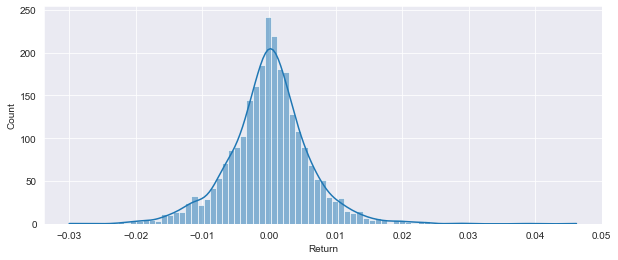

In [11]:
plt.figure(figsize=(10,4))
sns.histplot(rets['Return'], kde=True);

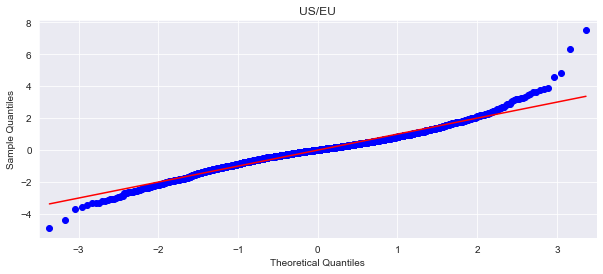

In [12]:
# Normal QQ plot of returns
fig, ax =plt.subplots(figsize=(10,4))
sm.graphics.qqplot(rets['Return'], line='s', fit=True, ax=ax)
plt.title('US/EU');

Obviously, the sample qantil values do not lie on straight line indicating "nonnormality". On the left and right sides there are many values that lie well below and above the line, respectively. In other words time series exhibits fat tails.

### Geometric Brownian Motion Model

The geometric Brownian motion model for $\{S(t), t\geq 0\}$ is defined by Itô stochastic differential equation,

$$
dS(t) = S(t)[\mu dt+\sigma dB(t)], \ \ S(0)>0.
$$

The solution of this equation satisfies

$$
S(t)=S(0)\exp\Big[(\mu-\frac{\sigma^2}{2})t+\sigma B(t)\Big],
$$

from which it follows at once that $X(t) = log(S(t))$ satisfies 

$$
X(t) = X(0) + (\mu-\frac{\sigma^2}{2})t+\sigma B(t),
$$

or equivalently

$$
dX(t) = (\mu-\frac{\sigma^2}{2})dt+\sigma dB(t).
$$


This implies that 

gen_path() generates sample Monte Carlo paths for Geometric Brownein Motion.

In [13]:
# This code credit to "Python for Finance: Mastering Data-Driven Finance" by Yves Hilpisch

def gen_paths(S0, r, sigma, T, M, I):
    '''Generate Monte carlo paths for Geometric Brownein Motion.
    
    Parameters
    ==========
    S0: float 
        initial/index level
    r: float
        constant short rate
    sigma: float
        constant vtality
    T: float
        final time horizon
    M: int
        number of time steps
    I: number of path to be stimulated
    
    Returns
    =======
    paths: ndarrays, shape (M+1,I)
        stimulated paths given the parameters
    '''
    
    dt = T/M
    paths = np.zeros((M + 1,I))
    paths[0] = S0
    for t in range(1, M + 1):
        rand = np.random.standard_normal(I)
        rand = (rand-rand.mean())/rand.std()
        paths[t] = paths[t - 1]*np.exp((r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*rand)
    return paths

In [14]:
S0 = 100.
r = 0.05
sigma = 0.2
T = 1.0
M = 50
I = 250000
np.random.seed(1000)

In [15]:
paths = gen_paths(S0, r, sigma, T, M, I)

In [16]:
S0*np.exp(r*T)

105.12710963760242

In [17]:
paths[-1].mean()

105.12645392478755

In [18]:
paths[:,0].round(4)

array([100.    ,  97.821 ,  98.5573, 106.1546, 105.899 ,  99.8363,
       100.0145, 102.6589, 105.6643, 107.1107, 108.7943, 108.2449,
       106.4105, 101.0575, 102.0197, 102.6052, 109.6419, 109.5725,
       112.9766, 113.0225, 112.5476, 114.5585, 109.942 , 112.6271,
       112.7502, 116.3453, 115.0443, 113.9586, 115.8831, 117.3705,
       117.9185, 110.5539, 109.9687, 104.9957, 108.0679, 105.7822,
       105.1585, 104.3304, 108.4387, 105.5963, 108.866 , 108.3284,
       107.0077, 106.0034, 104.3964, 101.0637,  98.3776,  97.135 ,
        95.4254,  96.4271,  96.3386])

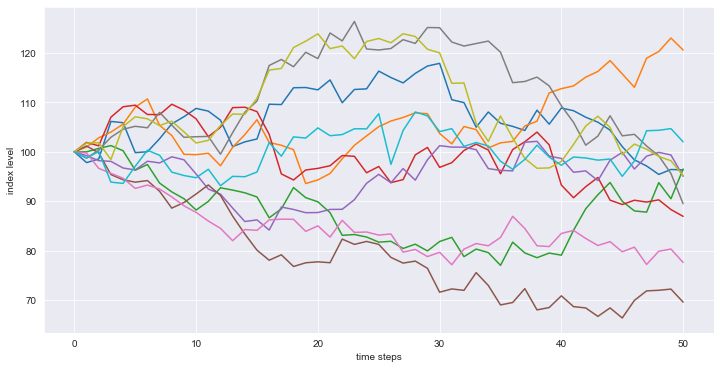

In [19]:
# Ten stimulation paths for Geometric Brownian Motion
plt.figure()
plt.plot(paths[:,:10])
plt.xlabel('time steps')
plt.ylabel('index level');

In [20]:
log_returns = np.log(paths[1:]/paths[:-1])

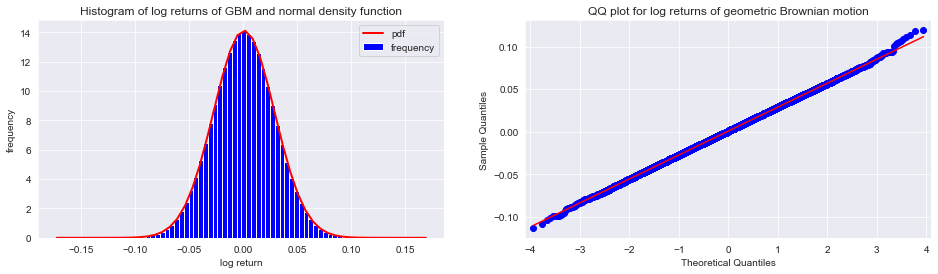

In [21]:
fig, ax = plt.subplots(1,2, figsize=(16, 4))
ax[0].hist(log_returns.flatten(), bins=70, density=True, label='frequency', color='b');
ax[0].set_xlabel('log return')
ax[0].set_ylabel('frequency')
ax[0].set_title('Histogram of log returns of GBM and normal density function')
x = np.linspace(ax[0].axis()[0], ax[0].axis()[1])
ax[0].plot(x, scs.norm.pdf(x, loc=r/M, scale=sigma/np.sqrt(M)), 'r', lw=2.0, label='pdf')
ax[0].legend()
sm.graphics.qqplot(log_returns.flatten()[::500], line='s', ax=ax[1])
ax[1].set_title('QQ plot for log returns of geometric Brownian motion');

### Time Dependence in Squared-Returns

Nonlinear time dependence in the time series of exchange rate returns is exhibited with the time dependence of the squared returns.
The autocorrelation function (ACF) and the partial autocorrelation function (PACF) are computed for the exchange rate returns and for their squared values. Marginally significant time dependence is present in the returns, while highly significant time dependence is apparent in the squared returns. (The blue lines in the plots are at +/- two standard deviations for the sample correlation coefficients under the null hypothesis of no time-series dependence.)

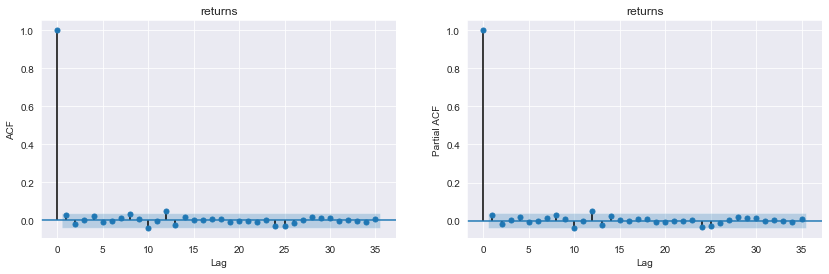

In [22]:
fig, ax = plt.subplots(1,2, figsize=(14, 4))
sm.graphics.tsa.plot_acf(rets.values.squeeze(), title ='returns', ax=ax[0])
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('ACF')
sm.graphics.tsa.plot_pacf(rets.values.squeeze(), title ='returns', ax=ax[1])
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Partial ACF')
plt.show()

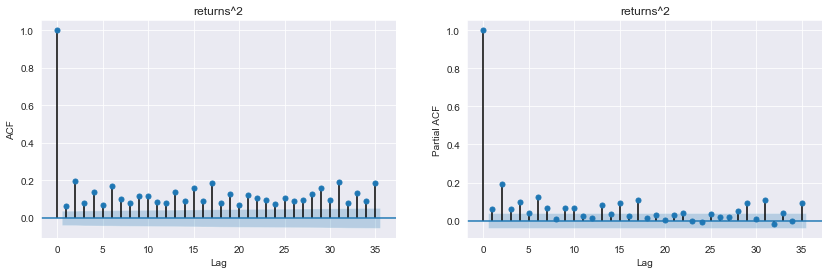

In [23]:
fig, ax = plt.subplots(1,2, figsize=(14, 4))
sm.graphics.tsa.plot_acf(rets.values.squeeze()**2, title ='returns^2', ax=ax[0])
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('ACF')
sm.graphics.tsa.plot_pacf(rets.values.squeeze()**2, title ='returns^2', ax=ax[1])
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Partial ACF')
plt.show()

### Gaussian ARCH and GARCH Models

The following models are fit the EUR/USD exchange rate: 

- ARCH(1)
- ARCH(2)
- ARCH(10)
- GARCH(1,1)

The python function arch_model() is fits both ARCH(p) and GARCH(p,q) models by maximum likelihood, assuming Gaussian distributions for the model innovations.

In [24]:
#import sys  
#!{sys.executable} -m pip install --user arch

In [25]:
from arch import arch_model
import warnings

In [76]:
warnings.filterwarnings("ignore")
am = arch_model(100*rets['Return'], p=1, q=0)
res1 = am.fit(update_freq=5)
print(res1.summary())

Iteration:      5,   Func. Count:     38,   Neg. LLF: 2191.6941027200633
Iteration:     10,   Func. Count:     78,   Neg. LLF: 2183.202659087334
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2183.086474157681
            Iterations: 14
            Function evaluations: 102
            Gradient evaluations: 14
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2183.09
Distribution:                  Normal   AIC:                           4374.17
Method:            Maximum Likelihood   BIC:                           4397.64
                                        No. Observations:                 2608
Date:                Mon, Nov 22 2021   Df Residuals:                     2607
Time:       

plot() can be used to quickly visualize the standardized residuals and conditional volatility.

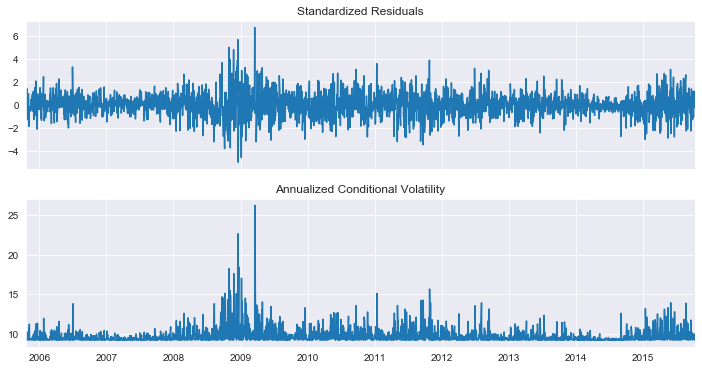

In [27]:
fig = res1.plot(annualize="D")

In [28]:
am = arch_model(100*rets['Return'], p=2, q=0)
res2 = am.fit(update_freq=5)
print(res2.summary())

Iteration:      5,   Func. Count:     42,   Neg. LLF: 2374.512902110685
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2371.830066102596
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2371.8300661025714
            Iterations: 10
            Function evaluations: 73
            Gradient evaluations: 10
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -2371.83
Distribution:                  Normal   AIC:                           4751.66
Method:            Maximum Likelihood   BIC:                           4775.13
                                        No. Observations:                 2608
Date:                Sun, Nov 21 2021   Df Residuals:                     2607
Time:        

In [29]:
am = arch_model(100*rets['Return'], p=10, q=0)
res10 = am.fit(update_freq=5)
print(res10.summary())

Iteration:      5,   Func. Count:     80,   Neg. LLF: 2303.4474151105883
Iteration:     10,   Func. Count:    155,   Neg. LLF: 2259.1464364755147
Iteration:     15,   Func. Count:    233,   Neg. LLF: 2251.63518588464
Iteration:     20,   Func. Count:    312,   Neg. LLF: 2250.616887357195
Iteration:     25,   Func. Count:    383,   Neg. LLF: 2250.557696484909
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2250.5576964850393
            Iterations: 25
            Function evaluations: 383
            Gradient evaluations: 25
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -2250.56
Distribution:                  Normal   AIC:                           4525.12
Method:            Maximum Likel

In [30]:
am = arch_model(100*rets['Return'], p=1, q=1)
res11 = am.fit(update_freq=5)
print(res11.summary())

Iteration:      5,   Func. Count:     38,   Neg. LLF: 2191.6941027200633
Iteration:     10,   Func. Count:     78,   Neg. LLF: 2183.202659087334
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2183.086474157681
            Iterations: 14
            Function evaluations: 102
            Gradient evaluations: 14
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2183.09
Distribution:                  Normal   AIC:                           4374.17
Method:            Maximum Likelihood   BIC:                           4397.64
                                        No. Observations:                 2608
Date:                Sun, Nov 21 2021   Df Residuals:                     2607
Time:       

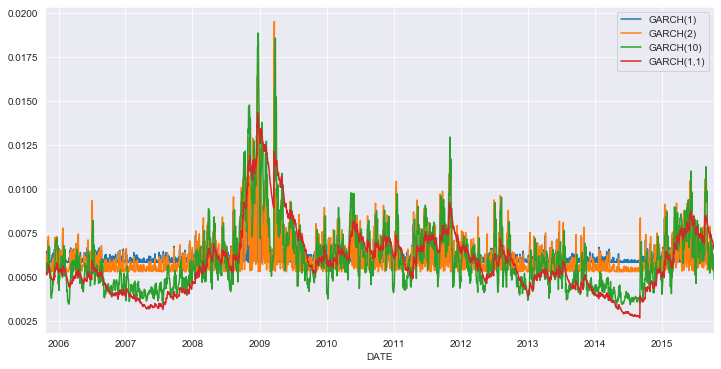

In [31]:
df = pd.concat([.01*res1.conditional_volatility, 
                .01*res2.conditional_volatility,
                .01*res10.conditional_volatility, 
                .01*res11.conditional_volatility],axis=1)
df.columns = ['GARCH(1)', 'GARCH(2)', 'GARCH(10)', 'GARCH(1,1)']
subplot = df.plot();
#subplot.set_xlim(xlim)

The estimated mean is $\hat{\mu} = 0.0049$ and the minimum-AICC GARCH model (with Gaussian noise) for the residuals,  is found to be the GARCH(1,1) with estimated parameter values $\hat{\alpha}_0 = 0.0010, \hat{\alpha}_1 = 0.0325, \hat{\beta}_1 = 0.9650$.

Note:
- The ARCH models have a hard lower bound ($\hat{α}_0$) which gets lower with
higher-order p values.
- The GARCH(1,1) model provides an extremely parsimonious model compared to that of the ARCH(10) model.
- The GARCH(1,1) model is quite smooth when compared to every ARCH
model.
- The GARCH(1,1) model is very close to being non-stationary 
$$
\hat{\alpha}_1 + \hat{\beta}_1 = 0.9975
$$
This near-non stationarity is consistent with there being no long-term mean volatility. Instead, the volatility evolves slowly over time (i.e., with high value $\beta_1$) with no tendency to revert toward any specific mean volatility level.

### AR(1)-GARCH(1,1) Models with t Distributions

In this section, we fit AR(1)-GARCH(1,1) model with t distributions for the innovations. This model explicitly incorporates non-linear dependence in the residuals (i.e., volatility) and provides a specific distribution alternative to the Gaussian with excess kurtosis (i.e., heavier tails).

In [122]:
am = arch_model(rets['Return'], mean='AR', lags=1, p=1, q=1, dist='StudentsT')
res11 = am.fit(update_freq=5)
print(res11.summary())

Iteration:      5,   Func. Count:     62,   Neg. LLF: -4044.097391968343
Iteration:     10,   Func. Count:    133,   Neg. LLF: 41834.76688127982
Iteration:     15,   Func. Count:    183,   Neg. LLF: 15256.291147191834
Iteration:     20,   Func. Count:    239,   Neg. LLF: 25101.459066206015
Iteration:     25,   Func. Count:    283,   Neg. LLF: 25066.252509233804
Iteration:     30,   Func. Count:    323,   Neg. LLF: 22649.57451713406
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 10948.938144351581
            Iterations: 36
            Function evaluations: 341
            Gradient evaluations: 32
                              AR - GARCH Model Results                              
Dep. Variable:                       Return   R-squared:                 -502145.785
Mean Model:                              AR   Adj. R-squared:            -502338.548
Vol Model:                            GARCH   Log-Likelihood:               -10948.9
Distribution

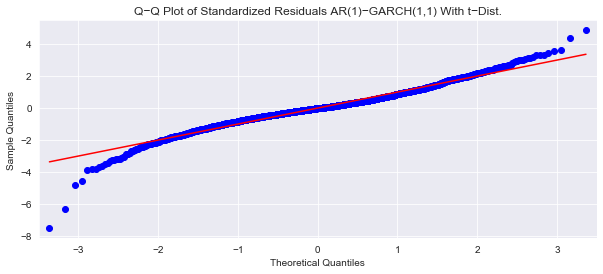

In [126]:
fig, ax =plt.subplots(figsize=(10,4))
sm.graphics.qqplot(res11.resid[1:], line='s', fit=True, ax=ax)
plt.title('Q−Q Plot of Standardized Residuals AR(1)−GARCH(1,1) With t−Dist.');

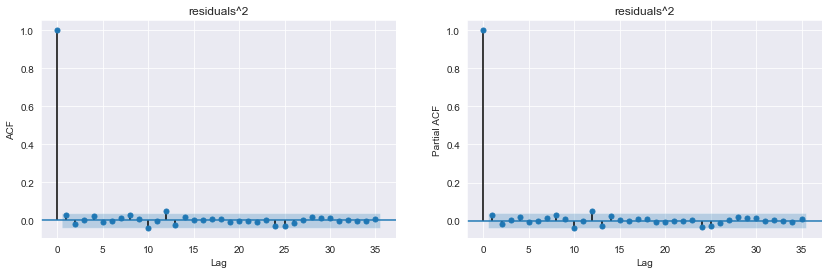

In [110]:
fig, ax = plt.subplots(1,2, figsize=(14, 4))
sm.graphics.tsa.plot_acf(res11.resid[1:]**2, title='residuals^2', ax=ax[0])
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('ACF')
sm.graphics.tsa.plot_pacf(res11.resid[1:]**2, title='residuals^2', ax=ax[1])
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Partial ACF')
plt.show()

Looks like we have achieved a good model fit as there is no obvious autocorrelation in the squared residuals.